In [76]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from datetime import datetime
import pyspark.sql.functions as f
from pyspark.sql.types import ArrayType, DateType, StringType, IntegerType
from pyspark.sql.functions import col
import datetime 
from math import *

%matplotlib inline


In [38]:
pdf = pd.read_csv('/home/yota/BigDataProject/dataset2.csv', index_col=0)
FMT = '%H:%M'
pdf = pdf.dropna()
pdf = pdf.drop(pdf[pdf.Exit > '25:00'].index)
exit = []
for value1 in pdf["Exit"]: 
    exit.append(datetime.datetime.strptime(str(value1), FMT))
entrance = []
for value2 in pdf["Entrance"]: 
    entrance.append(datetime.datetime.strptime(str(value2), FMT))
duration = []
for i in range(len(exit)):
    t = str(exit[i]-entrance[i]).replace(':','')[:-2]
    duration.append(str(t))

pdf["Duration"] = duration
pdf['Duration'] = pd.to_numeric(pdf['Duration'], errors='coerce')

tmp = []
for x in pdf["Exit"]:
    tmp.append(str(x).replace(':',''))
pdf["Exit"] = tmp
pdf['Exit'] = pd.to_numeric(pdf['Exit'], errors='coerce')

tmp2 = []   
for x in pdf["Entrance"]:
    tmp2.append(str(x).replace(':',''))
pdf["Entrance"] = tmp2
pdf['Entrance'] = pd.to_numeric(pdf['Entrance'], errors='coerce')

pdf = pdf.drop(['Factory', 'Department'], axis=1)

#pdf.info
pdf.to_csv('/home/yota/BigDataProject/dataset3.csv', index=False)



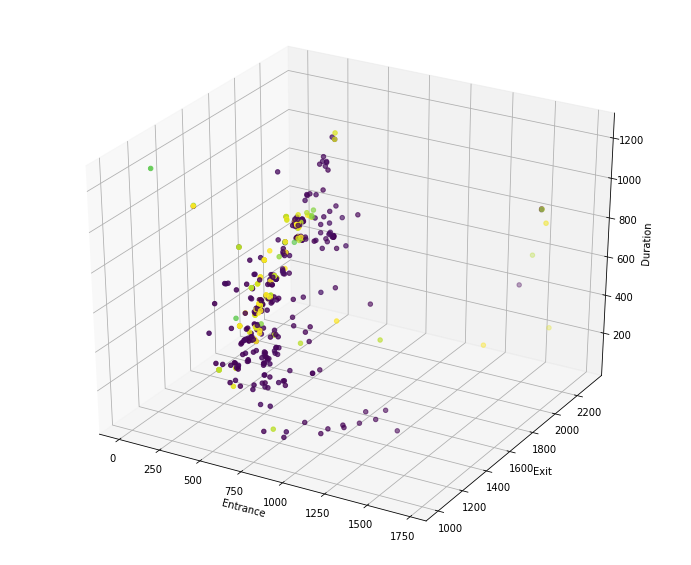

In [39]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pdf.Entrance, pdf.Exit, pdf.Duration, c=pdf.ID)
threedee.set_xlabel('Entrance')
threedee.set_ylabel('Exit')
threedee.set_zlabel('Duration')
plt.show()

In [40]:
sqlContext = SQLContext(sc)

In [52]:
df = sqlContext.read.csv("/home/yota/BigDataProject/dataset3.csv", header=True) # requires spark 2.0
FEATURES_COL = ['Entrance', 'Exit', 'Duration']

for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))

df = df.na.drop()
df = df.groupBy('ID').mean()

df = df.withColumnRenamed("avg(Entrance)", "Entrance").withColumnRenamed("avg(Exit)", "Exit").withColumnRenamed("avg(Duration)", "Duration")
df.show()

+------+-----------------+------------------+-----------------+
|    ID|         Entrance|              Exit|         Duration|
+------+-----------------+------------------+-----------------+
|  5052|605.0833333333334|           1255.25|630.1666666666666|
|169419|            627.0|            1524.0|            857.0|
|  1008|            757.0|            1634.0|            837.0|
|  2079|742.2857142857143|1498.2857142857142|750.2857142857143|
|142050|615.4285714285714|1247.2857142857142|614.7142857142857|
|  3074|            653.0|            1419.0|            726.0|
|169509|            624.5|            1478.5|            834.0|
|149309|561.8571428571429|1321.4285714285713|742.4285714285714|
|162028|612.3333333333334|1251.6666666666667|            626.0|
|151057|932.6666666666666|            1752.0|779.3333333333334|
|  3072|710.0909090909091|1245.4545454545455|517.1818181818181|
|139832|642.6666666666666|            1617.0|934.3333333333334|
|162142|            629.0|            15

In [53]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="Features")
df_kmeans = vecAssembler.transform(df).select('ID', 'Features')
df_kmeans.show()

+------+--------------------+
|    ID|            Features|
+------+--------------------+
|  5052|[605.083333333333...|
|169419|[627.0,1524.0,857.0]|
|  1008|[757.0,1634.0,837.0]|
|  2079|[742.285714285714...|
|142050|[615.428571428571...|
|  3074|[653.0,1419.0,726.0]|
|169509|[624.5,1478.5,834.0]|
|149309|[561.857142857142...|
|162028|[612.333333333333...|
|151057|[932.666666666666...|
|  3072|[710.090909090909...|
|139832|[642.666666666666...|
|162142|[629.0,1521.0,852.0]|
|139830|[516.0,1312.25,77...|
|  1227|[620.0,1533.0,913.0]|
|169818|[1074.5,1929.0,83...|
|162004|[925.333333333333...|
|  5130|[576.625,1428.875...|
|159100|[905.666666666666...|
|    98|[800.0,1600.0,800.0]|
+------+--------------------+
only showing top 20 rows



In [54]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("Features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

Text(0,0.5,u'cost')

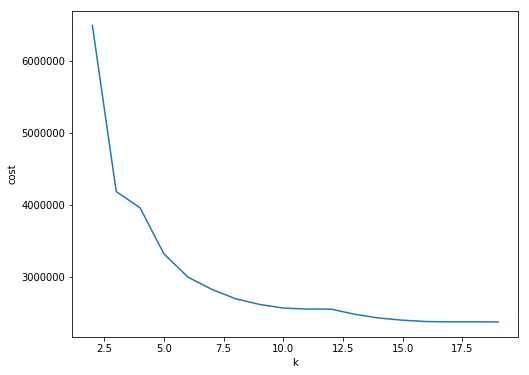

In [55]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [56]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("Features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 901.66666667 1479.          557.33333333]
[1507. 2328.  821.]
[ 669.75586081 1555.04111722  868.73214286]
[1006.0952381  1812.35714286  787.21428571]
[1506. 1844.  338.]
[ 600.78567244 1394.73735209  774.04397403]
[ 617.76645022 1230.04112554  598.51709957]
[ 619.82289916 1311.58592437  674.35966387]
[ 936.50505051 1305.48989899  350.6010101 ]
[ 727.58155535 1260.10088126  517.6461039 ]


In [71]:
centers[0][0]

901.6666666666667

In [57]:
transformed = model.transform(df_kmeans).select('ID', 'Prediction')
rows = transformed.collect()
print(rows[:3])

[Row(ID=u'5052', Prediction=6), Row(ID=u'169419', Prediction=2), Row(ID=u'1008', Prediction=2)]


In [58]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()


+------+----------+
|    ID|Prediction|
+------+----------+
|  5052|         6|
|169419|         2|
|  1008|         2|
|  2079|         2|
|142050|         6|
|  3074|         5|
|169509|         2|
|149309|         5|
|162028|         6|
|151057|         3|
|  3072|         9|
|139832|         2|
|162142|         2|
|139830|         5|
|  1227|         2|
|169818|         3|
|162004|         3|
|  5130|         5|
|159100|         3|
|    98|         2|
+------+----------+
only showing top 20 rows



In [59]:
df_pred = df_pred.join(df, 'ID')
df_pred.show()

+------+----------+-----------------+------------------+-----------------+
|    ID|Prediction|         Entrance|              Exit|         Duration|
+------+----------+-----------------+------------------+-----------------+
|  5052|         6|605.0833333333334|           1255.25|630.1666666666666|
|169419|         2|            627.0|            1524.0|            857.0|
|  1008|         2|            757.0|            1634.0|            837.0|
|  2079|         2|742.2857142857143|1498.2857142857142|750.2857142857143|
|142050|         6|615.4285714285714|1247.2857142857142|614.7142857142857|
|  3074|         5|            653.0|            1419.0|            726.0|
|169509|         2|            624.5|            1478.5|            834.0|
|149309|         5|561.8571428571429|1321.4285714285713|742.4285714285714|
|162028|         6|612.3333333333334|1251.6666666666667|            626.0|
|151057|         3|932.6666666666666|            1752.0|779.3333333333334|
|  3072|         9|710.09

In [67]:
pddf_pred = df_pred.toPandas().set_index('ID')
pddf_pred.head()

,Prediction,Entrance,Exit,Duration
ID,,,,
5052,6,605.083333,1255.250000,630.166667
169419,2,627.000000,1524.000000,857.000000
1008,2,757.000000,1634.000000,837.000000
2079,2,742.285714,1498.285714,750.285714
142050,6,615.428571,1247.285714,614.714286


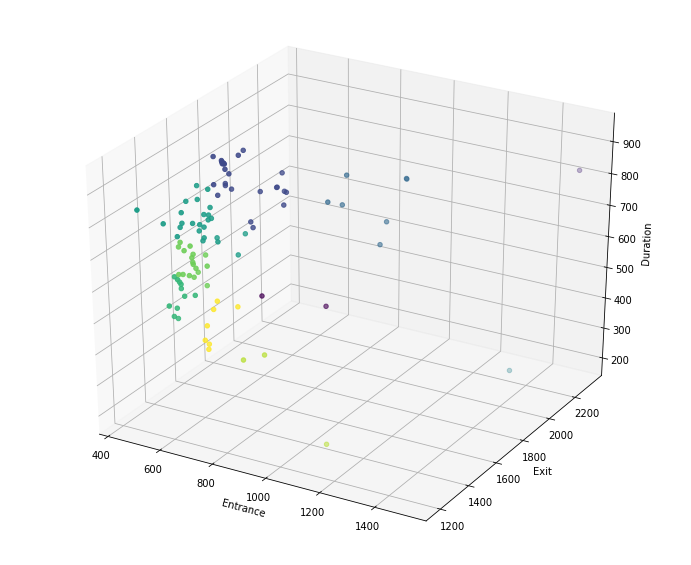

In [68]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.Entrance, pddf_pred.Exit, pddf_pred.Duration, c=pddf_pred.Prediction)
threedee.set_xlabel('Entrance')
threedee.set_ylabel('Exit')
threedee.set_zlabel('Duration')
plt.show()

In [80]:
def euclidian_distance(x,y,z,xc,yc,zc):
    return sqrt(pow((x-xc),2)+pow((y-yc),2)+pow((z-zc),2))

eucDis = []     
        
for i in pddf_pred.index:
    eucDis.append(euclidian_distance(pddf_pred['Entrance'][i],pddf_pred['Exit'][i],pddf_pred['Duration'][i],centers[pddf_pred['Prediction'][i]][0],centers[pddf_pred['Prediction'][i]][1],centers[pddf_pred['Prediction'][i]][2]))
pddf_pred["Euclidian_Distance"] = eucDis
pddf_pred

,Prediction,Entrance,Exit,Duration,Euclidian_Distance
ID,,,,,
5052,6,605.083333,1255.250000,630.166667,42.403348
169419,2,627.000000,1524.000000,857.000000,54.122618
1008,2,757.000000,1634.000000,837.000000,121.872777
2079,2,742.285714,1498.285714,750.285714,150.037701
142050,6,615.428571,1247.285714,614.714286,23.773733
3074,5,653.000000,1419.000000,726.000000,74.988236
169509,2,624.500000,1478.500000,834.000000,95.461811
149309,5,561.857143,1321.428571,742.428571,88.820839
162028,6,612.333333,1251.666667,626.000000,35.390572


In [91]:
pddf_pred.loc[pddf_pred.groupby("Prediction")["Euclidian_Distance"].idxmax()]

,Prediction,Entrance,Exit,Duration,Euclidian_Distance
ID,,,,,
110,0,816.333333,1419.000000,576.000000,105.972743
132301,1,1507.000000,2328.000000,821.000000,0.000000
98,2,800.000000,1600.000000,800.000000,153.977090
159100,3,905.666667,1703.333333,797.666667,148.597918
169720,4,1506.000000,1844.000000,338.000000,0.000000
131008,5,444.000000,1271.500000,817.500000,204.101980
169629,6,627.000000,1204.000000,537.000000,67.437024
102,7,669.500000,1320.500000,611.000000,81.004457
105,8,1105.181818,1321.636364,194.636364,230.298787


In [16]:
sc.stop()